<a href="https://colab.research.google.com/github/zanderVenter/GEE_misc/blob/master/multiclass_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import relevant libraries for this starter script:

In [2]:
import os
import rioxarray as rxr
import rasterio as rio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.patches import Patch
import numpy as np
from pathlib import Path

Reset root directory and list the image files

In [6]:
# root = Path('test-multiclass-segmentation/dset-s2-grunnkart')
root = Path("dset-s2-grunnkart")
assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

val_imgs = list((root/'val_scene').glob('*.tif'))
val_masks = list((root/'val_truth').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort() 
train_masks.sort()
val_imgs.sort()
val_masks.sort()

Open one image and one mask and plot:

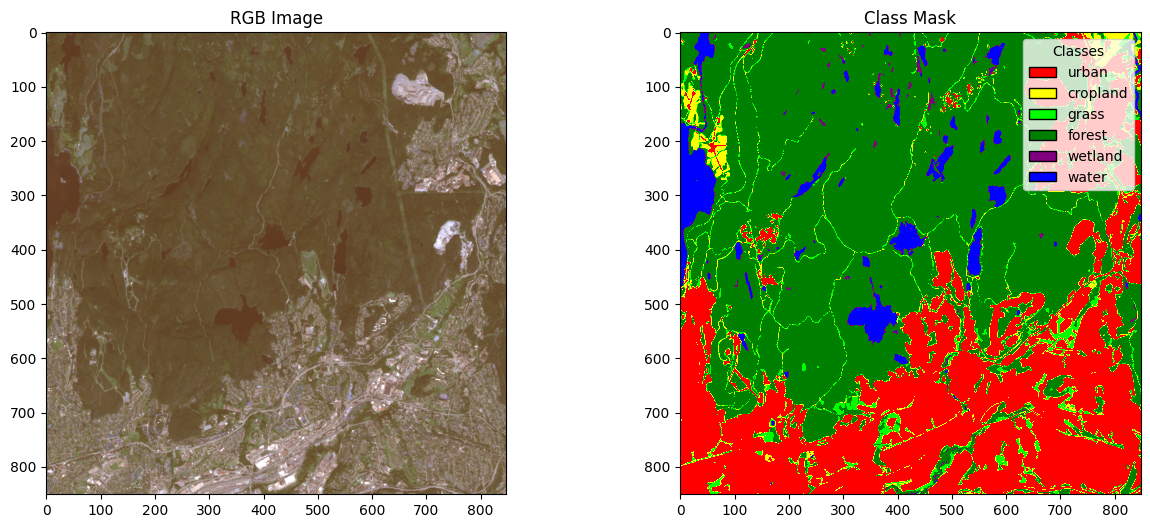

In [9]:
idx = 0
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

_, axs = plt.subplots(1, 2, figsize=(15, 6))

# Define the class labels and corresponding colors
class_labels = ['urban', 'cropland', 'grass', 'forest', 'wetland', 'water']
class_colors = ['red', 'yellow', 'lime', 'green', 'purple', 'blue']

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/2000
axs[0].imshow(rgb.clip(min=0, max=1))
axs[0].set_title("RGB Image")

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")
legend_elements = [Patch(facecolor=color, edgecolor='black', label=label)
                   for color, label in zip(class_colors, class_labels)]

# Add the legend to the second subplot
axs[1].legend(handles=legend_elements, loc='upper right', title="Classes")

**Continue from here on however you like**

The task is described in the GitHub readme.

### Prepare datasets

In [169]:
n_train = len(train_imgs)
n_val = len(val_imgs)
n_classes = len(class_labels)
n_bands = rxr.open_rasterio(train_imgs[0]).shape[0]

In [200]:
X_train = []
y_train = []
X_val = []
y_val = []

In [201]:
for i, (img_path, mask_path) in enumerate(zip(train_imgs, train_masks)):
    img = rxr.open_rasterio(img_path)
    mask = rxr.open_rasterio(mask_path).squeeze()
    X_train.append(img.data.astype(np.float32))
    
    y = np.zeros((6, *mask.shape))
    for label_idx in range(6):
        y[label_idx] = (mask.data == label_idx + 1).astype(np.float32)
    y_train.append(y)

In [202]:
for i, (img_path, mask_path) in enumerate(zip(val_imgs, val_masks)):
    img = rxr.open_rasterio(img_path)
    mask = rxr.open_rasterio(mask_path).squeeze()
    X_val.append(img.data.astype(np.float32))
    
    y = np.zeros((6, *mask.shape))
    for label_idx in range(6):
        y[label_idx] = (mask.data == label_idx + 1).astype(np.float32)
    y_val.append(y)

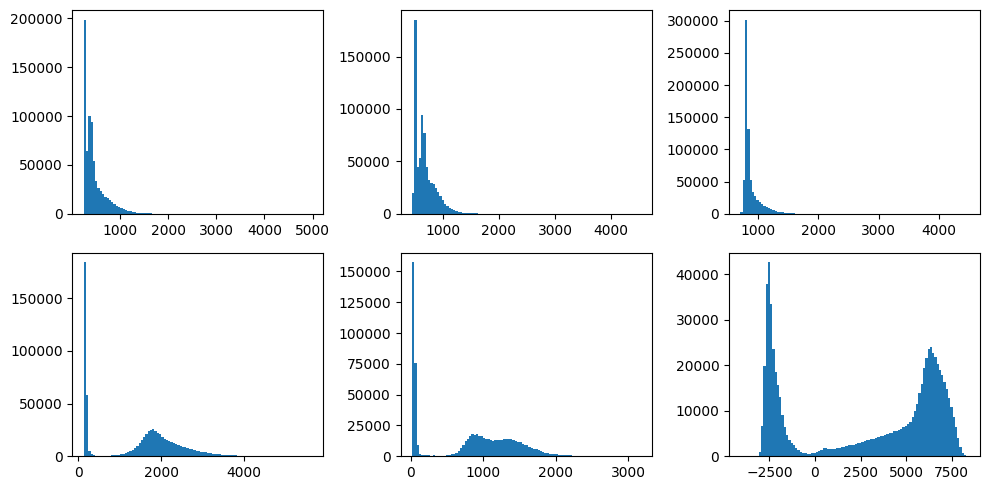

In [203]:
fig = plt.figure(figsize=(10,5))
for i in range(n_bands):
    ax = plt.subplot(2, 3, i+1)
    ax.hist(X_train[1][i].ravel(), bins=100)

plt.tight_layout()

In [204]:
band_mins = []
band_maxs = []
band_min = np.inf
band_max = -np.inf
for band_idx in range(n_bands):
    for X in X_train:
        band_min = min(band_min, np.min(X[band_idx]))
        band_max = max(band_max, np.max(X[band_idx]))
    print(band_idx, band_min, band_max)
    band_mins.append(band_min)
    band_maxs.append(band_max)    

0 235.0 9092.0
1 235.0 9092.0
2 235.0 9092.0
3 129.0 10254.0
4 17.0 11041.0
5 -4095.0 11041.0


In [205]:
for X in chain(X_train, X_val):
    for i, (bmin, bmax) in enumerate(zip(band_mins, band_maxs)):
        X[band_idx] = (X[band_idx] - bmin) / (bmax - bmin)

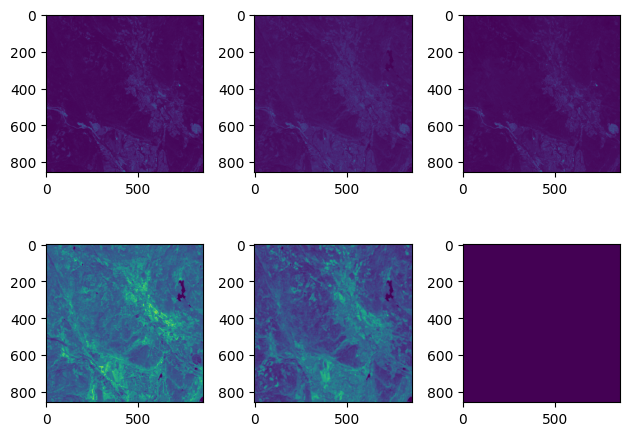

In [206]:
for i in range(n_bands):
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(X_train[2][i])

plt.tight_layout()

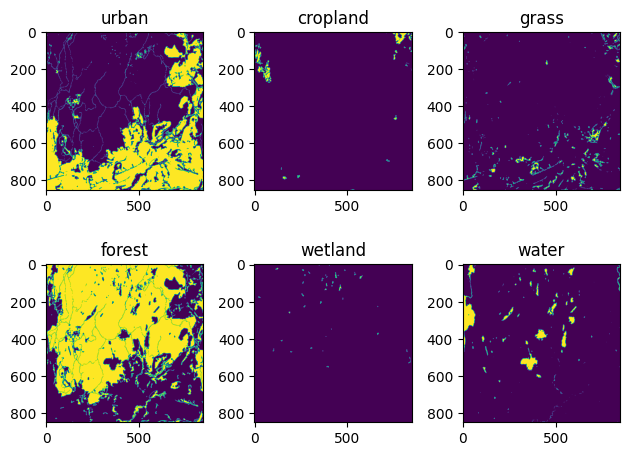

In [207]:
for i, label in enumerate(class_labels):
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(y_train[0][i])
    ax.set_title(label)

plt.tight_layout()

In [210]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullConv(nn.Module):

    def __init__(self, input_channels: int, num_filters: list[int], kernel_size=(3,3)):
        super(FullConv, self).__init__()

        conv_params = {
            'kernel_size': kernel_size,
            'padding': 'same'
        }
        self.conv_layers = []
        n_prev = input_channels
        for n in num_filters:
            self.conv_layers.append(
                nn.Conv2d(
                    in_channels = n_prev,
                    out_channels = n,
                    **conv_params
                )
            )
        self.conv_layers = nn.ModuleList(self.conv_layers)
    
    def forward(self, x):
        print(x.shape)
        for conv_layer in self.conv_layers[::-1]:
            x = F.relu(conv_layer(x))
        output = F.softmax(self.conv_layers[-1](x))
        return output

In [214]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullConv(nn.Module):

    def __init__(self, input_channels: int, output_channels: int):
        super(FullConv, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels = input_channels,
            out_channels = 128, 
            kernel_size=3
        )
        self.conv2 = nn.Conv2d(
            in_channels = 128,
            out_channels = 128,
            kernel_size=3
        )
        self.conv3 = nn.Conv2d(
            in_channels = 128,
            out_channels = output_channels,
            kernel_size=3
        )
    
    def forward(self, x):
        c1 = F.relu(self.conv1(x))
        c2 = F.relu(self.conv2(c1))
        out = F.softmax(self.conv3(c2), dim=0)
        return out

In [215]:
import torch.optim as optim

filters = [128, n_classes]
model = FullConv(input_channels=n_bands, output_channels=n_classes)
# Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

model.train()
print_period = 10
n_epochs = 10
for epoch in range(n_epochs):
    for X, y in zip(X_train, y_train):
        optimizer.zero_grad()
        outputs = model(torch.from_numpy(X))
        loss = criterion(outputs, torch.from_numpy(y))
        loss.backward()
        optimizer.step()
        print(loss.item())

RuntimeError: Expected target size [6, 842], got [6, 851, 848]